In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D

# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [9]:
def plot_timecourse(selected_rg_id, selected_site_base, selected_valtype_tc, ax, color=None) -> tuple[pd.DataFrame, pd.DataFrame, plt.Axes]:
    """Plot timecourse data and fitted curve for a given reaction group and nucleotide."""

    def _fmod_model(x: np.ndarray, log_kappa: float, log_kdeg: float, log_fmod_0: float) -> np.ndarray:
        kappa = np.exp(log_kappa)     # == kobs
        kdeg  = np.exp(log_kdeg)
        fmod0 = np.exp(log_fmod_0)
        return 1.0 - np.exp(-kappa * (1.0 - np.exp(-kdeg * x))) + fmod0

    # Fetch timecourse data
    timecourse_df = read_sql(
        """
        SELECT
            pr.rg_id,
            pr.reaction_time,
            pr.treated,
            pr.temperature,
            pr.replicate,
            pr.buffer_id,
            fv.fmod_val,
            fv.valtype,
            mn.site,
            mn.base,
            mn.site || '_' || UPPER(mn.base) AS site_base,
            s.sample_name
        FROM probe_reactions pr
        JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
        JOIN meta_nucleotides mn ON mn.id = fv.nt_id
        JOIN sequencing_samples s ON s.id = pr.s_id
        WHERE pr.rg_id = :rg_id
        AND mn.site || '_' || UPPER(mn.base) = :site_base
        AND fv.valtype = :valtype
        AND s.to_drop != 1
        AND fv.outlier != 1
        ORDER BY pr.reaction_time
        """,
        {"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype": selected_valtype_tc},
    )

    # Fetch fitted parameters
    fit_params_df = read_sql(
        """
        WITH run AS (
        SELECT id AS fit_run_id
        FROM probe_tc_fit_runs
        WHERE (rg_id, nt_id) IN (
            SELECT DISTINCT pr.rg_id, mn.id
            FROM probe_reactions pr
            JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
            JOIN meta_nucleotides mn ON mn.id = fv.nt_id
            WHERE pr.rg_id = :rg_id
            AND mn.site || '_' || UPPER(mn.base) = :site_base
        )
        AND fit_kind = 'round3_constrained'
        AND valtype = :valtype_mod
        )
        SELECT
        p.fit_run_id,
        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')    THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')    THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')  THEN p.param_numeric END) AS log_fmod0,
        MAX(CASE WHEN p.param_name =  'kobs'                    THEN p.param_numeric END) AS kobs,
        MAX(CASE WHEN p.param_name =  'kdeg'                    THEN p.param_numeric END) AS kdeg,
        MAX(CASE WHEN p.param_name =  'fmod0'                   THEN p.param_numeric END) AS fmod0,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')    THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')    THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')  THEN p.param_numeric END) AS log_fmod0_err,
        MAX(CASE WHEN p.param_name =  'diag:r2'                 THEN p.param_numeric END) AS diag_r2
        FROM probe_tc_fit_params p
        JOIN run r ON r.fit_run_id = p.fit_run_id
        GROUP BY p.fit_run_id
        """,
        {"rg_id": selected_rg_id, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
    )

    if timecourse_df.empty:
        print("No timecourse rows matched those filters.")
    else:
        # set untreated reaction_time to zero
        timecourse_df['reaction_time'] = timecourse_df['reaction_time'] * timecourse_df['treated']
        
        ax.scatter(timecourse_df["reaction_time"] / 3600., timecourse_df["fmod_val"] * 100., label=selected_rg_id, s = 8, color=color)

        # ---- build and add fitted curve if params exist ----
        if len(fit_params_df) >0:
            # choose best run if multiple (highest R^2)
            best = fit_params_df.sort_values("diag_r2", ascending=False).iloc[0]
            log_kobs  = float(best["log_kobs"])
            log_kdeg  = float(best["log_kdeg"])
            log_fmod0 = float(best["log_fmod0"])

            # x_fit domain from observed times (fall back to 0..max if needed)
            x_min = 0.0
            x_max = float(timecourse_df["reaction_time"].max())
            if x_min == x_max:
                x_min, x_max = 0.0, max(1.0, x_max)
            
            x_max = 50000

            x_fit = np.linspace(x_min, x_max, 10000)
            y_fit = _fmod_model(x_fit, log_kobs, log_kdeg, log_fmod0)

            ax.plot(x_fit / 3600., y_fit * 100., linewidth=1, color=color)

        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles=handles, labels=labels, loc="best")
    return timecourse_df, fit_params_df, ax

76 8.906e-02 9.939e-05
80 6.310e-02 2.233e-04
81 3.806e-02 1.224e-03
11 3.492e-02 2.801e-03


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


47 3.084e-02 9.568e-03
50 2.333e-02 2.876e-02


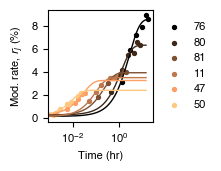

In [15]:
conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

fig, ax = plt.subplots(figsize=(2.25, 1.75))

# 76: 18C, 80: 25C, 81: 37C, 11: 45C, 47: 75C, 50: 80C

# set continuous color map magma
cmap = plt.get_cmap("copper")
colors = cmap(np.linspace(0, 1, 6))

for i, selected_rg_id in enumerate([76, 80, 81, 11, 47, 50]):
    tc, fit, ax = plot_timecourse(selected_rg_id, '18_A', 'modrate', ax, color=colors[i])
    print(
        selected_rg_id,
        f"{np.exp(fit['log_kobs'].values[0]):.3e}",
        f"{np.exp(fit['log_kdeg'].values[0]):.3e}",
    )
ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'Mod. rate, $r_j$ (%)')

# legend outside on the right
ax.legend(frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))

# x-axis in log scale
ax.set_xscale('log')

# no legend
plt.tight_layout()
plt.savefig('4U_wt_tempgrad_A18.pdf')
plt.show()

76 1.505e-02 9.939e-05
80 1.088e-02 2.233e-04
81 2.086e-02 1.224e-03
11 3.715e-02 2.801e-03


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


47 3.918e-02 9.568e-03
50 3.095e-02 2.876e-02


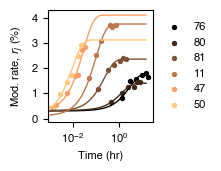

In [16]:
conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

fig, ax = plt.subplots(figsize=(2.25, 1.75))

# 76: 18C, 80: 25C, 81: 37C, 11: 45C, 47: 75C, 50: 80C

# set continuous color map magma
cmap = plt.get_cmap("copper")
colors = cmap(np.linspace(0, 1, 6))

for i, selected_rg_id in enumerate([76, 80, 81, 11, 47, 50]):
    tc, fit, ax = plot_timecourse(selected_rg_id, '22_A', 'modrate', ax, color=colors[i])
    print(
        selected_rg_id,
        f"{np.exp(fit['log_kobs'].values[0]):.3e}",
        f"{np.exp(fit['log_kdeg'].values[0]):.3e}",
    )
ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'Mod. rate, $r_j$ (%)')

# set x lim 0 to 8, tick every 2
# ax.set_xlim(0, 8)
# ax.set_xticks(np.arange(0, 9, 2))

# x-axis in log scale
ax.set_xscale('log')

# legend outside on the right
ax.legend(frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))

# no legend
plt.tight_layout()
plt.savefig('4U_wt_tempgrad_A22.pdf')
plt.show()